In [1]:
#import
# import findspark
# import itertools
# findspark.init()
# import pyspark
# sc = pyspark.SparkContext()
import pandas as pd
import numpy as np
import pickle
from surprise import Reader, Dataset
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity


# #Cài đặt:
# !pip install scikit-surprise==1.0.2
from surprise import SVD
import numpy as np
import surprise
from sklearn.model_selection import train_test_split
# from numpy.linalg import svd

**Start!!!!**

- Tài liệu tham khảo: [How to Build a Movie Recommendation System _ by Ramya Vidiyala _ Towards Data Science ](https://towardsdatascience.com/how-to-build-a-movie-recommendation-system-67e321339109)

- Github: https://github.com/RamyaVidiyala/MovieRecommenderSystem

## Tại sao chúng ta cần hệ thống giới thiệu?


Hiện nay chúng ta đang sống trong “kỷ nguyên của sự phong phú”. Đối với bất kỳ sản phẩm nhất định nào, đôi khi có hàng nghìn tùy chọn để bạn lựa chọn. Hãy nghĩ đến các ví dụ ở trên: phát video trực tuyến, mạng xã hội, mua sắm trực tuyến; Danh sách cứ kéo dài. Hệ thống đề xuất giúp cá nhân hóa nền tảng và giúp người dùng tìm thấy thứ họ thích.

Cách dễ nhất và đơn giản nhất để làm điều này là giới thiệu các mặt hàng phổ biến nhất. Tuy nhiên, để thực sự nâng cao trải nghiệm người dùng thông qua các đề xuất được cá nhân hóa, chúng tôi cần các hệ thống đề xuất chuyên dụng.

Từ quan điểm kinh doanh, người dùng càng tìm thấy nhiều sản phẩm có liên quan trên nền tảng, thì mức độ tương tác của họ càng cao. Điều này thường dẫn đến tăng doanh thu cho chính nền tảng. Nhiều nguồn tin khác nhau nói rằng có tới 35–40% doanh thu của các gã khổng lồ công nghệ chỉ đến từ các khuyến nghị.

Bây giờ chúng ta đã hiểu tầm quan trọng của hệ thống khuyến nghị, hãy cùng xem xét các loại hệ thống khuyến nghị, sau đó xây dựng dữ liệu nguồn mở của riêng chúng ta!

## Ý tưởng:

- Phương pháp dựa trên nội dung dựa trên sự giống nhau của các thuộc tính phim. Khi sử dụng hệ thống giới thiệu này, nếu người dùng xem một bộ phim, các bộ phim tương tự sẽ được khuyến nghị. 

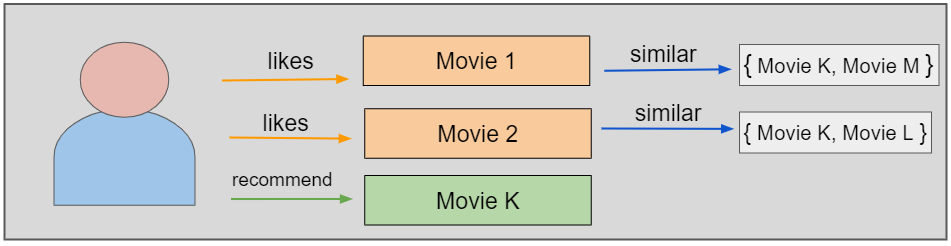

> Ví dụ: nếu người dùng xem một bộ phim hài có sự tham gia của Adam Sandler, hệ thống sẽ giới thiệu cho họ những bộ phim cùng thể loại hoặc có sự tham gia của cùng một diễn viên hoặc cả hai. Với suy nghĩ này, đầu vào để xây dựng hệ thống giới thiệu dựa trên nội dung là các thuộc tính phim.

## Phương pháp khuyến nghị:

- **Lọc dựa trên nội dung (Content-Based)**
- **Lọc cộng tác (Collaborative Filtering)**


## Thực hiện:

Đối với hệ thống đề xuất của chúng tôi, chúng tôi sẽ sử dụng cả hai kỹ thuật được đề cập ở trên: lọc dựa trên nội dung và lọc cộng tác. Để tìm sự giống nhau giữa các bộ phim cho phương pháp dựa trên nội dung của chúng tôi, chúng tôi sẽ sử dụng một hàm tương tự cosine (**cosine similarity**). Đối với phương pháp lọc cộng tác của chúng tôi, chúng tôi sẽ sử dụng kỹ thuật phân tích nhân tử ma trận (**matrix factorization**).

Bước đầu tiên hướng tới điều này là tạo ra một mô hình dựa trên thừa số hóa ma trận. Chúng tôi sẽ sử dụng đầu ra của mô hình này và một vài tính năng thủ công để cung cấp đầu vào cho mô hình cuối cùng. Quá trình cơ bản sẽ giống như sau:
- **Bước 1: Xây dựng mô hình dựa trên thừa số hóa ma trận**
- **Bước 2: Tạo các tính năng thủ công**
- **Bước 3: Triển khai mô hình cuối cùng**

### Bước 1: Xây dựng mô hình dựa trên thừa số hóa ma trận

In [2]:
# #Cài đặt:
# !pip install scikit-surprise==1.0.2
from surprise import SVD
import numpy as np
import surprise
from sklearn.model_selection import train_test_split
# from numpy.linalg import svd

In [35]:
df_ratings = pd.read_csv('Data/ml-25m/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [36]:
df_movies = pd.read_csv('Data/ml-25m/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [37]:
train_data = df_ratings.copy()

In [5]:
# train_data, test_data = train_test_split(df_ratings[:3000000], test_size=0.2, random_state=42, shuffle=True)
# train_data = df_ratings.copy()

In [6]:
# # It is to specify how to read the data frame.
# reader = Reader(rating_scale=(1,5))
# # create the traindata from the data frame
# train_data_mf = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)
# # build the train set from traindata. 
# #It is of dataset format from surprise library
# trainset = train_data_mf.build_full_trainset()
# svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
# svd.fit(trainset)

In [7]:
import pickle

In [8]:
# import pickle
# # save the model to disk
# filename = 'finalized_model.pkl'
# pickle.dump(svd, open(filename, 'wb'))

In [9]:
# with open('finalized_model.pkl', 'rb') as file:
#     pickle_model = pickle.load(file)

Bây giờ mô hình đã sẵn sàng. Chúng tôi sẽ lưu trữ những dự đoán này để chuyển đến mô hình cuối cùng như một tính năng bổ sung. Điều này sẽ giúp chúng tôi kết hợp tính năng lọc cộng tác vào hệ thống của mình.

In [10]:
# #getting predictions of train set
# train_preds = svd.test(trainset.build_testset())
# train_pred_mf = np.array([pred.est for pred in train_preds])

### Bước 2: Tạo các tính năng thủ công

Hãy chuyển đổi dữ liệu ở định dạng khung dữ liệu thành ma trận tương tác giữa người dùng và phim. Ma trận được sử dụng trong loại bài toán này thường thưa thớt vì có nhiều khả năng người dùng chỉ xếp hạng một vài bộ phim.

scipy.sparse.csr_matrix là một hàm tiện ích giúp chuyển đổi khung dữ liệu thành ma trận thưa thớt một cách hiệu quả.

In [38]:
# Creating a sparse matrix
train_sparse_matrix = sparse.csr_matrix((train_data.rating.values, 
                                         (train_data.userId.values, train_data.movieId.values)))

train_sparse_matrix' là biểu diễn ma trận thưa thớt của khung dữ liệu train_data.

Chúng tôi sẽ tạo 3 bộ tính năng bằng cách sử dụng ma trận thưa thớt này:
- Các tính năng đại diện cho mức trung bình toàn cầu
- Các tính năng đại diện cho năm người dùng tương tự hàng đầu
- Các tính năng đại diện cho năm bộ phim tương tự hàng đầu

Chúng ta hãy xem xét làm thế nào để chuẩn bị chi tiết hơn từng loại.

#### Tính năng gợi ý top phim được yêu thích nhất:


In [50]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)
def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}
    
    # return that dictionary of average ratings
    train_averages = dict()
    # get the average of ratings in our train set.
    train_averages['movie'] = average_ratings
    return train_averages

In [52]:
train_averages = get_average_ratings(train_sparse_matrix, of_users=False)
train_averages

{'movie': {1: 3.893707794587238,
  2: 3.2515271586594023,
  3: 3.142028126058963,
  4: 2.85354736424891,
  5: 3.0584343520573674,
  6: 3.854908898649748,
  7: 3.3636663369601054,
  8: 3.1145833333333335,
  9: 2.992050660199407,
  10: 3.42145763311516,
  11: 3.6571705198920315,
  12: 2.6245656241646618,
  13: 3.333527696793003,
  14: 3.4234888364494465,
  15: 2.7190217391304348,
  16: 3.8237068028689416,
  17: 3.948806325713417,
  18: 3.3843505768515074,
  19: 2.6421677802524126,
  20: 2.869921875,
  21: 3.5701620505454055,
  22: 3.3200173216412256,
  23: 3.145691333982473,
  24: 3.18758389261745,
  25: 3.677304434479322,
  26: 3.606708513142409,
  27: 3.4039315155358274,
  28: 4.03,
  29: 3.936724864539434,
  30: 3.6367924528301887,
  31: 3.244838567977158,
  32: 3.9057678412037236,
  33: 3.023076923076923,
  34: 3.6031917599186163,
  35: 3.4792899408284024,
  36: 3.91868681658758,
  37: 2.993333333333333,
  38: 2.870839936608558,
  39: 3.4187380861608845,
  40: 3.6267252195734003,
  4

- Tính số sao trung bình của toàn bộ phim trong dữ liệu:

In [45]:
def recommend_top(df_movies, train_averages, top = 10):
    top_n = list(dict(sorted(train_averages['movie'].items(), key=lambda item: item[1], reverse=True)).keys())[0:top]
    return df_movies.loc[df_movies.movieId.isin(top_n)]
    

In [46]:
recommend_top(df_movies, train_averages, top = 10)

,movieId,title,genres
9416,27914,"Hijacking Catastrophe: 9/11, Fear & the Sellin...",Documentary
9642,31945,Always a Bridesmaid (2000),Documentary
15771,83161,Deadly Delicious (Shuang Shi Ji) (2008),Drama|Mystery
16463,86975,As Seen Through These Eyes (2008),Documentary
17773,92783,Latin Music USA (2009),Documentary|Musical
18002,93991,"Eye for an Eye, An (Silmä silmästä) (1999)",Horror
18237,95494,Joffrey: Mavericks of American Dance (2012),Documentary
18505,96799,Puckoon (2002),Comedy
19040,99243,"Parasites, Les (1999)",Comedy
20049,103875,Iran Is Not the Problem (2008),Documentary


#### Tính năng gợi ý tên phim:


In [54]:
df_movies['title_lower'] = df_movies['title'].str.lower()

In [55]:
def find_movie(df_movies, key_word):
    key_word = key_word.lower()
    return df_movies[df_movies['title_lower'].str.contains(key_word)].iloc[:,:3]

In [58]:
find_movie(df_movies, 'MOTHER')

,movieId,title,genres
644,655,My Mother's Courage (Mutters Courage) (1995),Comedy
872,893,Mother Night (1996),Drama
1374,1412,Some Mother's Son (1996),Drama
1376,1414,Mother (1996),Comedy
1693,1768,Mother and Son (Mat i syn) (1997),Drama
...,...,...,...
60889,204400,The Disappearance of My Mother (2019),Documentary
61206,205271,Black Mother (2018),Documentary
61231,205327,Motherless Brooklyn (2019),Crime|Drama
61381,205729,Smother (2008),Comedy|Drama|Romance


#### Tính năng top 5 gợi ý user hàng đầu:


In [59]:
def top_similar_users(df_ratings, df_movies, train_sparse_matrix, user, top = 5):
    user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
    top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
    
    result = df_ratings[df_ratings.userId.isin(top_sim_users[:top])].sort_values(by=['rating'], ascending=False)
    result = df_movies.iloc[result[:top].movieId.to_list()]
    return result

In [60]:
top_similar_users(df_ratings, df_movies, train_sparse_matrix, 5, 5)

,movieId,title,genres,title_lower
1,2,Jumanji (1995),Adventure|Children|Fantasy,jumanji (1995)
1221,1254,"Treasure of the Sierra Madre, The (1948)",Action|Adventure|Drama|Western,"treasure of the sierra madre, the (1948)"
318,322,Swimming with Sharks (1995),Comedy|Drama,swimming with sharks (1995)
260,263,Ladybird Ladybird (1994),Drama,ladybird ladybird (1994)
50,51,Guardian Angel (1994),Action|Drama|Thriller,guardian angel (1994)


#### Tính năng top 5 người dùng giống bạn đánh giá phim đang xem:

In [17]:
def top_similar_users(train_sparse_matrix, user, movie):
    user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
    top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
    
    # get the ratings of most similar users for this movie
    top_ratings = train_sparse_matrix[top_sim_users, movie].toarray().ravel()
    # we will make it's length "5" by adding movie averages to
    top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
    
    return top_sim_users_ratings

In [18]:
top_similar_users(train_sparse_matrix, 4, 2)

[4.0, 2.5, 3.5, 3.5, 4.0]

#### Tính năng top 5 gợi ý film hàng đầu:


Trong tập hợp các tính năng này, chúng tôi có được 5 bộ phim tương tự hàng đầu do một người dùng cụ thể đánh giá. Sự tương đồng này được tính toán bằng cách sử dụng độ tương tự cosin giữa các bộ phim.

In [67]:

def top_5_similar_movies(df_movies, train_sparse_matrix, movie):
    movie = str(movie)
    if movie.isnumeric() == False:
        movie = df_movies.loc[df_movies.title == movie]
        if len(movie) == 0:
            return 'Invalid name'
        else:
            movie = movie.movieId.values[0]
    else: 
        movie = int(movie)
    # compute the similar movies of the "movie"
    movie_sim = cosine_similarity(train_sparse_matrix[:,movie].T,
                                  train_sparse_matrix.T).ravel()
    top_sim_movies = movie_sim.argsort()[::-1][1:]
    
    return df_movies.loc[df_movies.movieId.isin(top_sim_movies[0:5])].iloc[:,:3]

In [68]:
film = 'Mother Night (1996)'
top_5_similar_movies(df_movies, train_sparse_matrix, film)

,movieId,title,genres
850,869,Kansas City (1996),Crime|Drama|Musical|Thriller
1027,1051,Trees Lounge (1996),Drama
1090,1118,North Star (a.k.a. Tashunga) (1995),Action|Adventure|Crime|Drama|Western
1274,1308,I Shot a Man in Vegas (1995),Comedy
1285,1319,Kids of Survival (1996),Documentary


#### Tính sao trung bình của 1 user hay 1 bộ film:

In [21]:

# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)
def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

# Kết quả:

- Sao trung bình của toàn bộ dữ liệu:

In [22]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.533854451353085}

- Tính số sao trung bình của user tại ID i:

In [23]:
i = 5
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print(f'\nAverage rating of user {i} :',train_averages['user'][i])


Average rating of user 5 : 3.7524752475247523


- Tính số sao trung bình của movie tại ID i:

In [24]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][1000])


 AVerage rating of movie 15 : 3.116915422885572


In [25]:
top_10 = list(dict(sorted(train_averages['movie'].items(), key=lambda item: item[1], reverse=True)).keys())[0:10]
df_movies.loc[df_movies.movieId.isin(top_10)]
# sorted(train_averages['movie'].values(), reverse=True)

,movieId,title,genres,title_lower
9416,27914,"Hijacking Catastrophe: 9/11, Fear & the Sellin...",Documentary,"hijacking catastrophe: 9/11, fear & the sellin..."
9642,31945,Always a Bridesmaid (2000),Documentary,always a bridesmaid (2000)
15771,83161,Deadly Delicious (Shuang Shi Ji) (2008),Drama|Mystery,deadly delicious (shuang shi ji) (2008)
16463,86975,As Seen Through These Eyes (2008),Documentary,as seen through these eyes (2008)
17773,92783,Latin Music USA (2009),Documentary|Musical,latin music usa (2009)
18002,93991,"Eye for an Eye, An (Silmä silmästä) (1999)",Horror,"eye for an eye, an (silmä silmästä) (1999)"
18237,95494,Joffrey: Mavericks of American Dance (2012),Documentary,joffrey: mavericks of american dance (2012)
18505,96799,Puckoon (2002),Comedy,puckoon (2002)
19040,99243,"Parasites, Les (1999)",Comedy,"parasites, les (1999)"
20049,103875,Iran Is Not the Problem (2008),Documentary,iran is not the problem (2008)
